In [16]:
import pandas as pd
import geopandas as gpd
import os
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import math

In [18]:
from scipy import stats
def RMSE(df, p, x):
    return ((df[p] - df[x]) ** 2).mean() ** .5
    
def lregress(df, p, x):
    subset = df.dropna(subset=[p,x])
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset[x], subset[p])
    return(slope, intercept, r_value*r_value, p_value, std_err)

def validation_plot(x, y, data, title=None, x_label=None, y_label=None, alpha=.5, c=None, cmap=None, ax=None, size=40):
    slope, intercept, r2, p_value, std_err = lregress(data, y, x)
    rmse = RMSE(data, y, x)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if c is None:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, ax=ax, s=size)
    else:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, c=c, cmap=cmap, ax=ax, s=size)
    min_val = min(data[x].min(), data[y].min())
    max_val = max(data[x].max(), data[y].max())
    ax.plot([min_val,max_val], [min_val,max_val], c='black')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    val_text = "$r^2$: {r2:.5f}, slope: {slope:.2f}, intercept: {intercept:.5f}, RMSE: {rmse:.5f}".format(r2=r2, slope=slope, intercept=intercept, rmse=rmse)
    if title is None:
        ax.set_title("MX-drone ({x}) vs MX-drone ({y})\n{val}\n".format(x=x, y=y, val=val_text))
    else:
        ax.set_title(title)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

['Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/blue/Santaella_20220421_cruzado_definitivo_index_blue.tif', 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/green/Santaella_20220421_cruzado_definitivo_index_green.tif', 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red/Santaella_20220421_cruzado_definitivo_index_red.tif', 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red_edge/Santaella_20220421_cruzado_definitivo_index_red_edge.tif', 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_Su

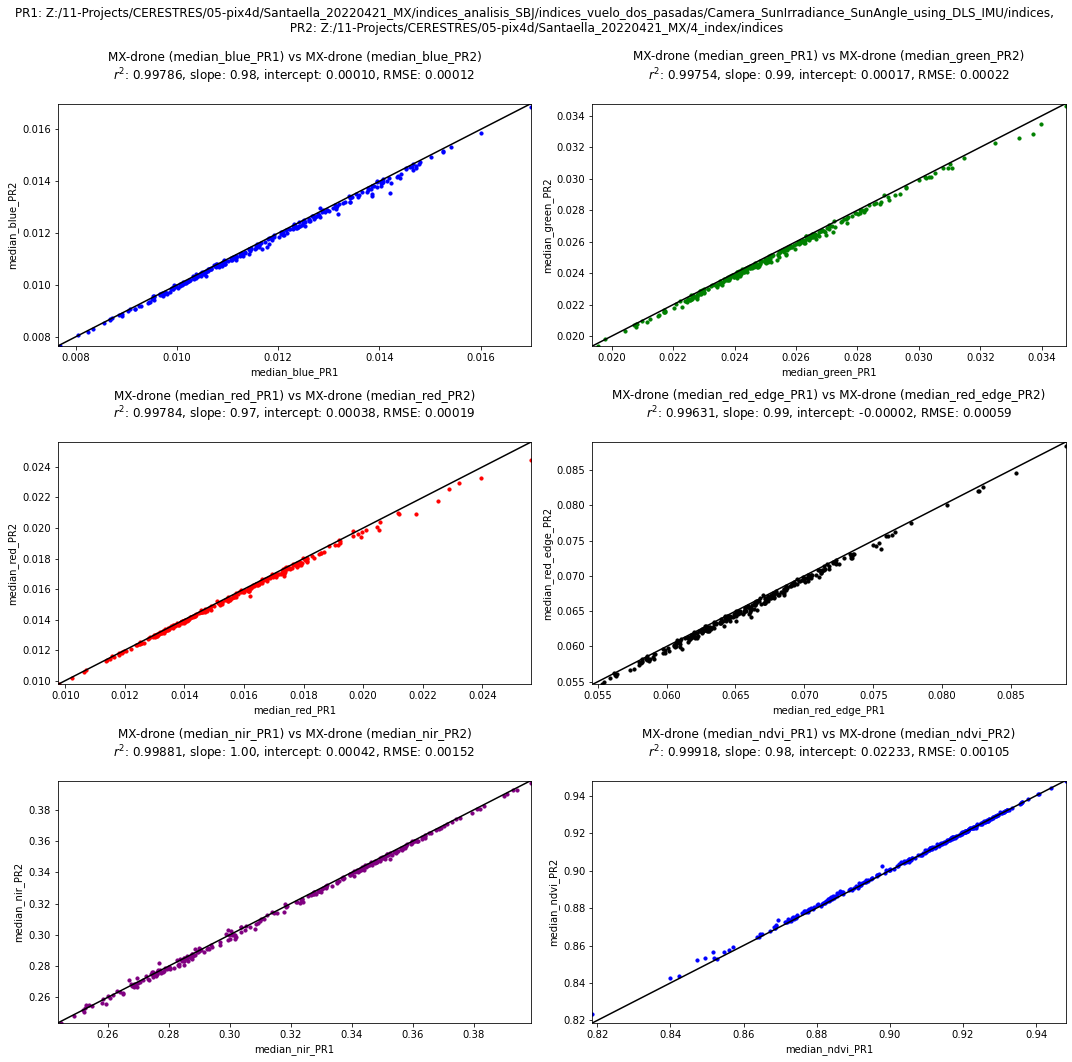

In [24]:
"""
def comparar_vuelos(dir_project_1, dir_project_2, index):
    import pandas as pd
    import geopandas as gpd
    import os
    from rasterstats import zonal_stats
    import matplotlib.pyplot as plt
"""
dir_project_1 = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices"
dir_project_2 = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices"
index = ['blue', 'green', 'red', 'red_edge', 'nir', 'ndvi']
stats_computed = 'mean median std'
    
#Obtener rutas de ficheros TIF
ficheros_tifs_proyecto_1 = []
ficheros_tifs_proyecto_2 = []
proyectos = [dir_project_1, dir_project_2]
for proyecto in proyectos:
    for indice in index:
        ruta = proyecto + '/' + indice + '/'
        for file in os.listdir(ruta):
            if file.endswith('.tif'):
                if proyecto == proyectos[0]:
                    ficheros_tifs_proyecto_1.append(ruta + file)
                else:
                    ficheros_tifs_proyecto_2.append(ruta + file)

#Extraer shapefiles RIEGO Y SECANO
geometry_riego = gpd.read_file('Z:/11-Projects/CERESTRES/02-ensayo/Santaella/Shapefiles/00-raw/riego/plots_regadio.shp')
geometry_riego['tipo'] = 'riego'
geometry_secano = gpd.read_file('Z:/11-Projects/CERESTRES/02-ensayo/Santaella/Shapefiles/00-raw/secano/plots_secano.shp')
geometry_secano['tipo'] = 'secano'
geometry_total = pd.concat([geometry_riego, geometry_secano])

#Apply zonal statistics and join dataframes
    #Project 1
print(ficheros_tifs_proyecto_1)
print('\n')
print(ficheros_tifs_proyecto_2)
contador = 0
for tif in ficheros_tifs_proyecto_1:
        df = pd.DataFrame(zonal_stats(geometry_total, tif, stats=stats_computed)).add_suffix('_' + index[contador])
        if contador == 0:
            df_proyecto_1 = df
        else:
            df_proyecto_1 = df_proyecto_1.join(df)
        contador += 1
        
    #Project 2
contador = 0
for tif in ficheros_tifs_proyecto_2:
        df = pd.DataFrame(zonal_stats(geometry_total, tif, stats=stats_computed)).add_suffix('_' + index[contador])
        if contador == 0:
            df_proyecto_2 = df
        else:
            df_proyecto_2 = df_proyecto_2.join(df)
        contador += 1

df_stats = pd.merge(df_proyecto_1, df_proyecto_2, left_index=True, right_index=True, suffixes=['_PR1','_PR2'])
plot_stat = 'median_'

#Plotear con la función
colors = ['b','g','r','k','purple']
contador_colors = 0
columnas_plot = 2
filas_plot = math.ceil(len(index)/2)
fig, axarr = plt.subplots(filas_plot,columnas_plot, figsize=(15,15))
axarr_fila = 0
axarr_columna = 0
for contador in range(len(index)):
    color = colors[contador_colors]
    validation_plot(plot_stat+index[contador]+'_PR1', plot_stat+index[contador]+'_PR2',df_stats,  ax=axarr[axarr_fila][axarr_columna], alpha=1, c=color)
    #Actualizar el plot en el que pinto
    if axarr_columna == 0:
        axarr_columna = 1
    else:
        axarr_columna = 0
        axarr_fila += 1
    #Actualizar color de la gráfica
    if contador_colors == (len(colors)-1):
        contador_colors = 0
    else:
        contador_colors+=1
        
fig.suptitle("PR1: {}, \n PR2: {} \n".format(dir_project_1, dir_project_2))    
fig.tight_layout()
plt.savefig('comparativa_1.png')

In [15]:
index

['blue', 'green', 'red', 'red_edge', 'nir', 'ndvi']

In [35]:
for i=1 in len(index):
    print(i)

SyntaxError: invalid syntax (<ipython-input-35-dad48ee75231>, line 1)

In [29]:
df_proyecto_2

,mean_blue,std_blue,median_blue,mean_green,std_green,median_green,mean_red,std_red,median_red,mean_red_edge,std_red_edge,median_red_edge,mean_nir,std_nir,median_nir
0,0.013189,0.002862,0.012375,0.028105,0.005038,0.027024,0.017097,0.004057,0.015941,0.070454,0.011440,0.068300,0.354018,0.044321,0.358259
1,0.015270,0.002658,0.014650,0.029869,0.004584,0.028816,0.018207,0.003578,0.017239,0.076090,0.011410,0.073083,0.372590,0.041018,0.373917
2,0.017037,0.002007,0.016843,0.034736,0.003833,0.034609,0.019999,0.002129,0.019798,0.088283,0.008851,0.088376,0.394520,0.031837,0.397429
3,0.011431,0.002428,0.010941,0.026617,0.004951,0.025593,0.014594,0.003180,0.013899,0.072680,0.011853,0.070101,0.371856,0.031094,0.370569
4,0.010566,0.001286,0.010433,0.024271,0.002477,0.024174,0.013921,0.001631,0.013759,0.067026,0.006422,0.066824,0.359143,0.030964,0.362491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.014132,0.002015,0.013803,0.033180,0.004207,0.032569,0.021789,0.003425,0.020949,0.077397,0.010506,0.076225,0.273187,0.030990,0.275679
275,0.015538,0.002401,0.015180,0.034197,0.004096,0.033471,0.024412,0.004320,0.023296,0.075671,0.011047,0.073873,0.276778,0.029209,0.278806
276,0.014062,0.002092,0.013996,0.033058,0.004034,0.032837,0.024788,0.004278,0.024437,0.071431,0.010067,0.071617,0.256991,0.035545,0.262554
277,0.012381,0.001939,0.011858,0.026594,0.003693,0.025665,0.016716,0.002606,0.016041,0.066321,0.010238,0.063885,0.270423,0.034359,0.272994


In [5]:
ficheros_tifs_proyecto_1

['Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/blue/Santaella_20220421_cruzado_definitivo_index_blue.tif',
 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/green/Santaella_20220421_cruzado_definitivo_index_green.tif',
 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red/Santaella_20220421_cruzado_definitivo_index_red.tif',
 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red_edge/Santaella_20220421_cruzado_definitivo_index_red_edge.tif',
 'Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradianc

In [54]:
from scipy import stats
def RMSE(df, p, x):
    return ((df[p] - df[x]) ** 2).mean() ** .5
    
def lregress(df, p, x):
    subset = df.dropna(subset=[p,x])
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset[x], subset[p])
    return(slope, intercept, r_value*r_value, p_value, std_err)

def validation_plot(x, y, data, title=None, x_label=None, y_label=None, alpha=.5, c=None, cmap='jet', ax=None, size=40):
    slope, intercept, r2, p_value, std_err = lregress(data, y, x)
    rmse = RMSE(data, y, x)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if c is None:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, ax=ax, s=size)
    else:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, c=c, cmap=cmap, ax=ax, s=size)
    min_val = min(data[x].min(), data[y].min())
    max_val = max(data[x].max(), data[y].max())
    ax.plot([min_val,max_val], [min_val,max_val], c='black')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    val_text = "$r^2$: {r2:.5f}, slope: {slope:.2f}, intercept: {intercept:.5f}, RMSE: {rmse:.5f}".format(r2=r2, slope=slope, intercept=intercept, rmse=rmse)
    if title is None:
        ax.set_title("MX-drone ({x}) vs MX-drone ({y})\n{val}\n".format(x=x, y=y, val=val_text))
    else:
        ax.set_title(title)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

In [34]:
tiff_cruzado_SBJ_BLUE = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/blue/Santaella_20220421_cruzado_definitivo_index_blue.tif"
tiff_cruzado_SBJ_GREEN = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/green/Santaella_20220421_cruzado_definitivo_index_green.tif"
tiff_cruzado_SBJ_RED = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red/Santaella_20220421_cruzado_definitivo_index_red.tif"
tiff_cruzado_SBJ_REDEDGE = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/red_edge/Santaella_20220421_cruzado_definitivo_index_red_edge.tif"
tiff_cruzado_SBJ_NIR = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/indices_analisis_SBJ/indices_vuelo_dos_pasadas/Camera_SunIrradiance_SunAngle_using_DLS_IMU/indices/nir/Santaella_20220421_cruzado_definitivo_index_nir.tif"
tiff_cruzado_SBJ = [tiff_cruzado_SBJ_BLUE, tiff_cruzado_SBJ_GREEN, tiff_cruzado_SBJ_RED, tiff_cruzado_SBJ_REDEDGE, tiff_cruzado_SBJ_NIR]

tiff_cruzado_ORIGINAL_BLUE = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices/blue/Santaella_20220421_MX_index_blue.tif"
tiff_cruzado_ORIGINAL_GREEN = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices/green/Santaella_20220421_MX_index_green.tif"
tiff_cruzado_ORIGINAL_RED = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices/red/Santaella_20220421_MX_index_red.tif"
tiff_cruzado_ORIGINAL_REDEDGE = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices/red_edge/Santaella_20220421_MX_index_red_edge.tif"
tiff_cruzado_ORIGINAL_NIR = "Z:/11-Projects/CERESTRES/05-pix4d/Santaella_20220421_MX/4_index/indices/nir/Santaella_20220421_MX_index_nir.tif"
tiff_cruzado_ORIGINAL = [tiff_cruzado_ORIGINAL_BLUE, tiff_cruzado_ORIGINAL_GREEN, tiff_cruzado_ORIGINAL_RED, tiff_cruzado_ORIGINAL_REDEDGE, tiff_cruzado_ORIGINAL_NIR]

In [35]:
#EXTRACT SHAPEFILES OF RIEGO AND SECANO
geometry_riego = gpd.read_file('Z:/11-Projects/CERESTRES/02-ensayo/Santaella/Shapefiles/00-raw/riego/plots_regadio.shp')
geometry_riego['tipo'] = 'riego'
geometry_secano = gpd.read_file('Z:/11-Projects/CERESTRES/02-ensayo/Santaella/Shapefiles/00-raw/secano/plots_secano.shp')
geometry_secano['tipo'] = 'secano'
geometry_total = pd.concat([geometry_riego, geometry_secano])

In [40]:
stats_computed = 'mean median std'
df_cruzado_SBJ_BLUE = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_SBJ[0], stats = stats_computed)).rename(columns={"mean": "MX_mean_BLUE", "median": "MX_median_BLUE", "std": "MX_std_BLUE"})
df_cruzado_SBJ_GREEN = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_SBJ[1], stats = stats_computed)).rename(columns={"mean": "MX_mean_GREEN", "median": "MX_median_GREEN", "std": "MX_std_GREEN"})
df_cruzado_SBJ_RED = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_SBJ[2], stats = stats_computed)).rename(columns={"mean": "MX_mean_RED", "median": "MX_median_RED", "std": "MX_std_RED"})
df_cruzado_SBJ_REDEDGE = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_SBJ[3], stats = stats_computed)).rename(columns={"mean": "MX_mean_REDEDGE", "median": "MX_median_REDEDGE", "std": "MX_std_REDEDGE"})
df_cruzado_SBJ_NIR = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_SBJ[4], stats = stats_computed)).rename(columns={"mean": "MX_mean_NIR", "median": "MX_median_NIR", "std": "MX_std_NIR"})
df_cruzado_SBJ = df_cruzado_SBJ_BLUE.join(df_cruzado_SBJ_GREEN).join(df_cruzado_SBJ_RED).join(df_cruzado_SBJ_REDEDGE).join(df_cruzado_SBJ_NIR)

df_cruzado_ORIGINAL_BLUE = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_ORIGINAL[0], stats = stats_computed)).rename(columns={"mean": "MX_mean_BLUE", "median": "MX_median_BLUE", "std": "MX_std_BLUE"})
df_cruzado_ORIGINAL_GREEN= pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_ORIGINAL[1], stats = stats_computed)).rename(columns={"mean": "MX_mean_GREEN", "median": "MX_median_GREEN", "std": "MX_std_GREEN"})
df_cruzado_ORIGINAL_RED= pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_ORIGINAL[2], stats = stats_computed)).rename(columns={"mean": "MX_mean_RED", "median": "MX_median_RED", "std": "MX_std_RED"})
df_cruzado_ORIGINAL_REDEDGE = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_ORIGINAL[3], stats = stats_computed)).rename(columns={"mean": "MX_mean_REDEDGE", "median": "MX_median_REDEDGE", "std": "MX_std_REDEDGE"})
df_cruzado_ORIGINAL_NIR = pd.DataFrame(zonal_stats(geometry_total, tiff_cruzado_ORIGINAL[4], stats = stats_computed)).rename(columns={"mean": "MX_mean_NIR", "median": "MX_median_NIR", "std": "MX_std_NIR"})
df_cruzado_ORIGINAL = df_cruzado_ORIGINAL_BLUE.join(df_cruzado_ORIGINAL_GREEN).join(df_cruzado_ORIGINAL_RED).join(df_cruzado_ORIGINAL_REDEDGE).join(df_cruzado_ORIGINAL_NIR)

In [41]:
df_cruzado_SBJ

,MX_mean_BLUE,MX_std_BLUE,MX_median_BLUE,MX_mean_GREEN,MX_std_GREEN,MX_median_GREEN,MX_mean_RED,MX_std_RED,MX_median_RED,MX_mean_REDEDGE,MX_std_REDEDGE,MX_median_REDEDGE,MX_mean_NIR,MX_std_NIR,MX_median_NIR
0,0.013495,0.003210,0.012496,0.028563,0.005336,0.027173,0.017354,0.004422,0.015913,0.071425,0.012167,0.068733,0.356253,0.043715,0.359267
1,0.015487,0.002805,0.014668,0.030261,0.004795,0.029007,0.018426,0.003809,0.017296,0.076772,0.011905,0.073584,0.373088,0.041532,0.374158
2,0.017101,0.002026,0.016992,0.034870,0.003698,0.034772,0.019981,0.002141,0.019674,0.088738,0.008906,0.088954,0.396112,0.029900,0.398704
3,0.011617,0.002663,0.010943,0.027038,0.005368,0.025781,0.014856,0.003594,0.013951,0.073447,0.012403,0.070461,0.373112,0.030223,0.371305
4,0.010684,0.001505,0.010463,0.024514,0.002723,0.024284,0.014059,0.001905,0.013753,0.067447,0.006947,0.066811,0.360929,0.029310,0.363114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.014394,0.002375,0.013857,0.033961,0.004771,0.033247,0.022470,0.004295,0.021217,0.078501,0.011573,0.076548,0.275169,0.032578,0.277458
275,0.015861,0.002781,0.015259,0.035078,0.004406,0.033977,0.025543,0.005219,0.023954,0.077145,0.011816,0.075540,0.278774,0.031037,0.280174
276,0.014347,0.002408,0.014149,0.034185,0.004537,0.033719,0.025980,0.004844,0.025633,0.073062,0.011407,0.072527,0.260159,0.036858,0.264923
277,0.012806,0.002516,0.012015,0.027345,0.004802,0.025860,0.017313,0.003642,0.016223,0.067852,0.011953,0.064495,0.272870,0.036208,0.274836


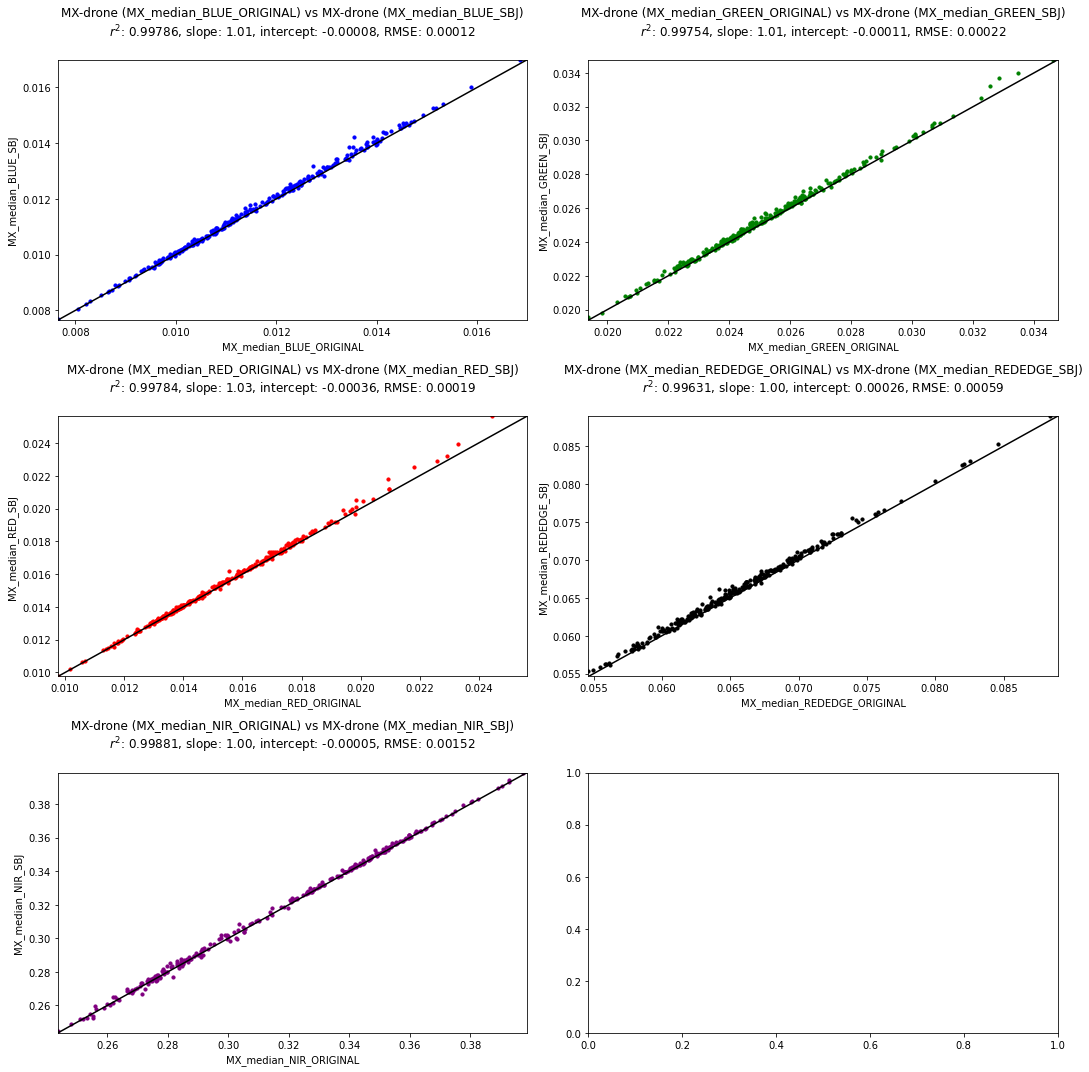

In [43]:
df_stats = pd.merge(df_cruzado_ORIGINAL, df_cruzado_SBJ, left_index=True, right_index=True, suffixes=['_ORIGINAL','_SBJ'])
#Plotear con la función
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_median_BLUE_ORIGINAL', 'MX_median_BLUE_SBJ',df_stats,  ax=axarr[0][0], alpha=1, c='blue')
validation_plot('MX_median_GREEN_ORIGINAL', 'MX_median_GREEN_SBJ',df_stats, ax=axarr[0][1], alpha=1, c='green')
validation_plot('MX_median_RED_ORIGINAL', 'MX_median_RED_SBJ',df_stats,  ax=axarr[1][0], alpha=1, c='red')
validation_plot('MX_median_REDEDGE_ORIGINAL', 'MX_median_REDEDGE_SBJ',df_stats, ax=axarr[1][1], alpha=1, c='k')
validation_plot('MX_median_NIR_ORIGINAL', 'MX_median_NIR_SBJ',df_stats,  ax=axarr[2][0], alpha=1, c='purple')
fig.tight_layout()